In [ ]:
%pip install scikit-surprise

In [117]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
import seaborn as sns
import math
%matplotlib inline

<Figure size 500x500 with 0 Axes>

In [118]:
chunksize = 10 ** 7
num_of_chunk = 0
data = pd.DataFrame()

for chunk in pd.read_csv('/kaggle/input/avazu-ctr-prediction/train.gz',chunksize=chunksize):
    num_of_chunk = num_of_chunk + 1
    data = pd.concat([train,chunk.sample(frac=0.01)],axis = 0,ignore_index = True)
    print(f'NUMBER {str(num_of_chunk)} is done.')

NUMBER 1 is done.
NUMBER 2 is done.
NUMBER 3 is done.
NUMBER 4 is done.
NUMBER 5 is done.


In [119]:
train = data.copy()

In [120]:
train.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,8.124319e+18,1,14102208,1005,0,6399eda6,968765cd,f028772b,ecad2386,7801e8d9,...,1,0,21768,320,50,2506,0,35,100076,157
1,7.300144e+18,1,14102108,1005,1,e023ba3e,75f9ddc3,f028772b,ecad2386,7801e8d9,...,1,0,21665,320,50,2493,3,35,-1,117
2,4.295121e+18,0,14102221,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,...,1,0,17262,320,50,1872,3,39,-1,23
3,7.834576e+18,0,14102302,1005,0,85f751fd,c4e18dd6,50e219e0,7358e05e,b9528b13,...,1,0,1037,320,50,178,3,1327,100148,15
4,1.839742e+19,0,14102215,1005,0,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,...,1,0,21831,320,50,2522,0,35,-1,221


In [121]:
train.isnull().sum()

id                  0
click               0
hour                0
C1                  0
banner_pos          0
site_id             0
site_domain         0
site_category       0
app_id              0
app_domain          0
app_category        0
device_id           0
device_ip           0
device_model        0
device_type         0
device_conn_type    0
C14                 0
C15                 0
C16                 0
C17                 0
C18                 0
C19                 0
C20                 0
C21                 0
dtype: int64

In [122]:
train.dtypes

id                  float64
click                 int64
hour                  int64
C1                    int64
banner_pos            int64
site_id              object
site_domain          object
site_category        object
app_id               object
app_domain           object
app_category         object
device_id            object
device_ip            object
device_model         object
device_type           int64
device_conn_type      int64
C14                   int64
C15                   int64
C16                   int64
C17                   int64
C18                   int64
C19                   int64
C20                   int64
C21                   int64
dtype: object

In [123]:
num_columns = ['id', 'click', 'hour', 'C1', 'banner_pos', 'device_type',
               'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18',
               'C19', 'C20', 'C21']

corr_matrix = train[num_columns].corr()

corr_matrix.style.background_gradient(cmap='coolwarm')

,id,click,hour,C1,banner_pos,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
id,1.000000,0.000428,0.001585,-0.001498,-0.002805,-0.001794,0.000298,0.002401,0.001686,0.001014,0.002539,-0.003323,-0.001801,0.000236,-0.000606
click,0.000428,1.000000,-0.007060,-0.036132,0.026880,-0.038233,-0.080817,-0.059264,-0.028581,0.127663,-0.054632,0.022744,-0.004554,-0.057990,-0.067877
hour,0.001585,-0.007060,1.000000,-0.005335,0.022404,-0.006732,0.046503,0.202095,0.022543,0.003676,0.193283,0.014125,0.038467,0.024136,0.063579
C1,-0.001498,-0.036132,-0.005335,1.000000,0.290599,0.894004,0.193699,0.053712,0.118927,0.065988,0.061888,-0.037628,-0.000421,-0.035021,0.031825
banner_pos,-0.002805,0.026880,0.022404,0.290599,1.000000,0.325908,-0.081306,-0.012961,0.060103,0.030658,-0.032650,0.099871,0.130380,0.054466,-0.103660
device_type,-0.001794,-0.038233,-0.006732,0.894004,0.325908,1.000000,0.207404,0.042060,0.175294,0.068591,0.047925,-0.042485,-0.003906,-0.049025,0.031918
device_conn_type,0.000298,-0.080817,0.046503,0.193699,-0.081306,0.207404,1.000000,0.065486,0.069364,-0.014473,0.077910,-0.062989,-0.006920,0.087145,0.065372
C14,0.002401,-0.059264,0.202095,0.053712,-0.012961,0.042060,0.065486,1.000000,0.002868,0.035910,0.977215,-0.230586,-0.132875,0.023926,0.405871
C15,0.001686,-0.028581,0.022543,0.118927,0.060103,0.175294,0.069364,0.002868,1.000000,-0.079825,0.001543,0.009759,0.052817,0.010809,0.002544
C16,0.001014,0.127663,0.003676,0.065988,0.030658,0.068591,-0.014473,0.035910,-0.079825,1.000000,0.046230,0.083568,-0.071511,-0.043570,-0.083609


In [124]:
train.click.value_counts()

click
0    342402
1     70468
Name: count, dtype: int64

<Axes: >

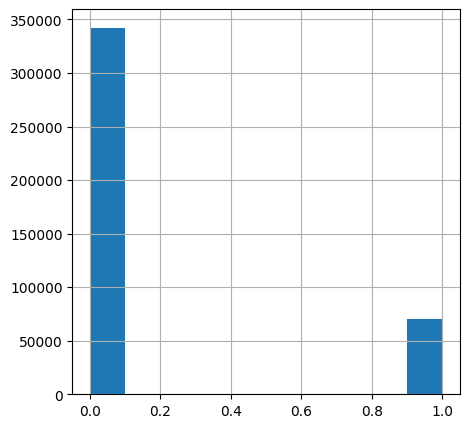

In [125]:
train.click.hist(figsize=(5, 5))

In [126]:
train.device_type.value_counts()

device_type
1    381398
0     22304
4      7885
5      1283
Name: count, dtype: int64

In [127]:
train.device_conn_type.value_counts()

device_conn_type
0    356382
2     34078
3     21989
5       421
Name: count, dtype: int64

In [128]:
train.device_model.value_counts()

device_model
8a4875bd    24800
1f0bc64f    14633
d787e91b    14171
76dc4769     7749
be6db1d7     7580
            ...  
297cccf1        1
91888a5e        1
bb01a955        1
6a405edf        1
975dbbc4        1
Name: count, Length: 4363, dtype: int64

In [129]:
X = train.copy()

In [130]:
X = X.drop(['id', 'site_id', 'site_domain', 'app_id', 'app_domain', 'device_ip', 'device_id'], axis=1)

In [131]:
X = X.drop(['device_type', 'C14'], axis=1) # Нужно ли удалять корреляции???

In [132]:
X.head()

,click,hour,C1,banner_pos,site_category,app_category,device_model,device_conn_type,C15,C16,C17,C18,C19,C20,C21
0,1,14102208,1005,0,f028772b,07d7df22,8a4875bd,0,320,50,2506,0,35,100076,157
1,1,14102108,1005,1,f028772b,07d7df22,00b1f3a7,0,320,50,2493,3,35,-1,117
2,0,14102221,1005,1,f028772b,07d7df22,2c67c536,0,320,50,1872,3,39,-1,23
3,0,14102302,1005,0,50e219e0,cef3e649,84ebbcd4,0,320,50,178,3,1327,100148,15
4,0,14102215,1005,0,f028772b,07d7df22,8a4875bd,0,320,50,2522,0,35,-1,221


In [133]:
X.head()

,click,hour,C1,banner_pos,site_category,app_category,device_model,device_conn_type,C15,C16,C17,C18,C19,C20,C21
0,1,14102208,1005,0,f028772b,07d7df22,8a4875bd,0,320,50,2506,0,35,100076,157
1,1,14102108,1005,1,f028772b,07d7df22,00b1f3a7,0,320,50,2493,3,35,-1,117
2,0,14102221,1005,1,f028772b,07d7df22,2c67c536,0,320,50,1872,3,39,-1,23
3,0,14102302,1005,0,50e219e0,cef3e649,84ebbcd4,0,320,50,178,3,1327,100148,15
4,0,14102215,1005,0,f028772b,07d7df22,8a4875bd,0,320,50,2522,0,35,-1,221


In [134]:
X['site_category'] = X['site_category'].astype('category')
X['site_category'] = X['site_category'].cat.codes

X['app_category'] = X['app_category'].astype('category')
X['app_category'] = X['app_category'].cat.codes

X['device_model'] = X['device_model'].astype('category')
X['device_model'] = X['device_model'].cat.codes

In [135]:
X.head()

,click,hour,C1,banner_pos,site_category,app_category,device_model,device_conn_type,C15,C16,C17,C18,C19,C20,C21
0,1,14102208,1005,0,19,0,2342,0,320,50,2506,0,35,100076,157
1,1,14102108,1005,1,19,0,8,0,320,50,2493,3,35,-1,117
2,0,14102221,1005,1,19,0,726,0,320,50,1872,3,39,-1,23
3,0,14102302,1005,0,5,19,2259,0,320,50,178,3,1327,100148,15
4,0,14102215,1005,0,19,0,2342,0,320,50,2522,0,35,-1,221


In [136]:
X['hour'] = pd.to_datetime(X['hour'], format = '%y%m%d%H')

In [137]:
X['day'] = X['hour'].dt.day

In [138]:
# X['month'] = X['hour'].dt.month

In [139]:
#X['year'] = X['hour'].dt.year

In [140]:
X['hour'] = X['hour'].dt.hour

In [141]:
X.head()

,click,hour,C1,banner_pos,site_category,app_category,device_model,device_conn_type,C15,C16,C17,C18,C19,C20,C21,day
0,1,8,1005,0,19,0,2342,0,320,50,2506,0,35,100076,157,22
1,1,8,1005,1,19,0,8,0,320,50,2493,3,35,-1,117,21
2,0,21,1005,1,19,0,726,0,320,50,1872,3,39,-1,23,22
3,0,2,1005,0,5,19,2259,0,320,50,178,3,1327,100148,15,23
4,0,15,1005,0,19,0,2342,0,320,50,2522,0,35,-1,221,22


In [142]:
X.describe()

,click,hour,C1,banner_pos,site_category,app_category,device_model,device_conn_type,C15,C16,C17,C18,C19,C20,C21,day
count,412870.000000,412870.000000,412870.000000,412870.000000,412870.000000,412870.000000,412870.000000,412870.000000,412870.000000,412870.000000,412870.000000,412870.000000,412870.000000,412870.000000,412870.000000,412870.000000
mean,0.170678,11.483014,1004.970102,0.288217,8.620733,2.818769,2174.442163,0.329954,318.874919,60.243244,2118.702340,1.434156,226.230605,53183.601787,83.461927,25.563579
std,0.376228,6.073007,1.089557,0.509644,7.284316,5.796568,1236.162371,0.852122,20.851659,47.674871,608.128083,1.326661,349.988567,49959.083058,70.621332,3.001065
min,0.000000,0.000000,1001.000000,0.000000,0.000000,0.000000,0.000000,0.000000,120.000000,20.000000,112.000000,0.000000,33.000000,-1.000000,1.000000,21.000000
25%,0.000000,7.000000,1005.000000,0.000000,3.000000,0.000000,1059.000000,0.000000,320.000000,50.000000,1863.000000,0.000000,35.000000,-1.000000,23.000000,23.000000
50%,0.000000,12.000000,1005.000000,0.000000,5.000000,0.000000,2269.000000,0.000000,320.000000,50.000000,2331.000000,2.000000,39.000000,100048.000000,61.000000,26.000000
75%,0.000000,16.000000,1005.000000,1.000000,19.000000,3.000000,3222.000000,0.000000,320.000000,50.000000,2526.000000,3.000000,171.000000,100094.000000,101.000000,28.000000
max,1.000000,23.000000,1012.000000,7.000000,20.000000,23.000000,4362.000000,5.000000,1024.000000,1024.000000,2757.000000,3.000000,1839.000000,100248.000000,255.000000,30.000000


In [143]:
X.shape

(412870, 16)

In [144]:
corr_matrix = X.corr()

corr_matrix.style.background_gradient(cmap='coolwarm')

,click,hour,C1,banner_pos,site_category,app_category,device_model,device_conn_type,C15,C16,C17,C18,C19,C20,C21,day
click,1.000000,-0.000098,-0.036132,0.026880,-0.004822,-0.047080,-0.002424,-0.080817,-0.028581,0.127663,-0.054632,0.022744,-0.004554,-0.057990,-0.067877,-0.007073
hour,-0.000098,1.000000,0.009264,-0.001764,-0.013340,0.039919,0.005177,0.028926,-0.003593,0.009996,-0.026410,0.024600,0.002665,0.019221,-0.066003,0.099236
C1,-0.036132,0.009264,1.000000,0.290599,0.031040,0.092629,0.086810,0.193699,0.118927,0.065988,0.061888,-0.037628,-0.000421,-0.035021,0.031825,-0.005534
banner_pos,0.026880,-0.001764,0.290599,1.000000,0.531268,-0.224615,0.056822,-0.081306,0.060103,0.030658,-0.032650,0.099871,0.130380,0.054466,-0.103660,0.022489
site_category,-0.004822,-0.013340,0.031040,0.531268,1.000000,-0.241711,0.031729,-0.157122,-0.002601,-0.107327,-0.015704,0.139499,0.108871,0.102133,-0.115734,0.010737
app_category,-0.047080,0.039919,0.092629,-0.224615,-0.241711,1.000000,-0.007136,0.237641,0.041311,-0.065922,0.023329,0.078792,0.020749,-0.057143,0.072258,0.045405
device_model,-0.002424,0.005177,0.086810,0.056822,0.031729,-0.007136,1.000000,0.000943,-0.006759,-0.008629,-0.025760,0.050150,0.006711,0.017910,-0.030208,-0.004528
device_conn_type,-0.080817,0.028926,0.193699,-0.081306,-0.157122,0.237641,0.000943,1.000000,0.069364,-0.014473,0.077910,-0.062989,-0.006920,0.087145,0.065372,0.046021
C15,-0.028581,-0.003593,0.118927,0.060103,-0.002601,0.041311,-0.006759,0.069364,1.000000,-0.079825,0.001543,0.009759,0.052817,0.010809,0.002544,0.022665
C16,0.127663,0.009996,0.065988,0.030658,-0.107327,-0.065922,-0.008629,-0.014473,-0.079825,1.000000,0.046230,0.083568,-0.071511,-0.043570,-0.083609,0.003482


In [145]:
import math
from sklearn import preprocessing
from sklearn.decomposition import PCA


# Функция для стандартизации фич
def scale_features(df):
    scaled = preprocessing.StandardScaler().fit_transform(df)
    scaled = pd.DataFrame(scaled, columns=df.columns)
    return scaled


In [146]:
X_scaled = preprocessing.scale(X.drop('click', axis=1))

In [147]:
X_scaled.shape

(412870, 15)

In [148]:
pca = PCA(n_components=15)
pca.fit(X_scaled)
print(pca.explained_variance_ratio_)
X_scaled.shape

[0.14044312 0.10927169 0.09535501 0.07942515 0.0762982  0.06748771
 0.06594279 0.06320652 0.06051443 0.05819129 0.04829817 0.04435437
 0.03929393 0.02633757 0.02558003]


(412870, 15)

In [149]:
pca.singular_values_

array([932.61529482, 822.63299414, 768.46491524, 701.34438532,
       687.39988205, 646.49422569, 639.05162015, 625.65258489,
       612.18372464, 600.31789967, 546.91221022, 524.10763242,
       493.30445886, 403.86867211, 398.01811676])

In [150]:
X_new = pca.transform(X_scaled)

In [151]:
X_new.shape

(412870, 15)

In [152]:
pd.DataFrame(pca.components_, columns=X.columns[1:])

,hour,C1,banner_pos,site_category,app_category,device_model,device_conn_type,C15,C16,C17,C18,C19,C20,C21,day
0,0.023551,0.015864,0.382103,0.397866,-0.219941,0.076961,-0.203545,0.010070,0.023687,-0.352080,0.422736,0.219115,0.083783,-0.484240,-0.079488
1,-0.069230,0.261692,0.486657,0.433823,-0.295565,0.048064,-0.054397,0.081007,-0.072296,0.367904,-0.324415,0.006000,0.106110,0.356902,0.134154
2,0.152300,0.509872,0.145343,-0.057333,0.431720,0.138710,0.523765,0.326596,-0.030339,0.006615,0.159723,0.184675,0.094206,-0.090277,0.167932
3,-0.055198,0.385839,0.138556,-0.110778,-0.079074,0.153641,-0.022629,-0.156659,0.625556,0.057204,0.082498,-0.409791,-0.402490,-0.073221,-0.158154
4,-0.483393,0.187956,0.020324,-0.030592,0.024024,0.075258,0.039998,0.246000,-0.303019,-0.276214,-0.184121,0.021297,-0.138062,0.081945,-0.658068
5,0.063853,0.012990,0.065690,0.036771,0.094307,-0.476857,-0.264340,0.429134,-0.122650,0.016591,0.068626,0.055205,-0.654320,0.004445,0.220314
6,-0.293007,0.023534,0.040117,-0.030047,-0.089461,-0.746010,0.231051,0.056371,0.375184,0.051741,0.019096,0.079336,0.351351,-0.068509,-0.108372
7,-0.758408,-0.105592,-0.041901,0.014112,0.187007,0.230118,-0.069368,-0.097078,0.080099,0.228694,0.245917,0.245285,-0.102096,0.005808,0.346031
8,-0.074946,-0.144010,-0.144725,-0.145730,-0.291372,0.253063,-0.116932,0.747799,0.159656,0.065714,0.071844,-0.288039,0.269613,-0.083936,0.109427
9,0.138490,0.050379,-0.037670,-0.274971,-0.186269,0.155090,-0.160552,0.095139,0.384966,-0.108490,-0.294287,0.737934,-0.072581,0.099656,-0.036848


In [153]:
Y = X['click']
Y

0         1
1         1
2         0
3         0
4         0
         ..
412865    0
412866    1
412867    0
412868    0
412869    0
Name: click, Length: 412870, dtype: int64

In [154]:
from sklearn.model_selection import train_test_split

X_train, X_valid, Y_train, Y_valid = train_test_split(X_new, Y, test_size=0.1, random_state=42)

In [155]:
model = SVD(n_factors=5, n_epochs=100, lr_all=0.005, reg_all=0.1, biased=True, random_state=42) # хз зачем мне это

In [159]:
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

sgd = SGDClassifier(
    loss='log_loss', # log_loss - логистическая регрессия, вероятностный классификатор
    penalty='l2',
    n_iter_no_change=35,
    shuffle=True,
    max_iter=5500,
    warm_start=True
)

rfc = RandomForestClassifier(
    n_estimators=10,
    max_depth=6
)

catboost = CatBoostClassifier(iterations=1000)


In [160]:
# sgd.partial_fit(X_train, Y_train, classes=np.unique(Y_train))
# sgd.fit(X_train, Y_train)
catboost.fit(X_train, Y_train)

Learning rate set to 0.128928
0:	learn: 0.6249825	total: 135ms	remaining: 2m 14s
1:	learn: 0.5754368	total: 200ms	remaining: 1m 39s
2:	learn: 0.5398574	total: 266ms	remaining: 1m 28s
3:	learn: 0.5137758	total: 324ms	remaining: 1m 20s
4:	learn: 0.4938279	total: 384ms	remaining: 1m 16s
5:	learn: 0.4791105	total: 454ms	remaining: 1m 15s
6:	learn: 0.4687491	total: 525ms	remaining: 1m 14s
7:	learn: 0.4602930	total: 590ms	remaining: 1m 13s
8:	learn: 0.4539911	total: 661ms	remaining: 1m 12s
9:	learn: 0.4490101	total: 722ms	remaining: 1m 11s
10:	learn: 0.4452437	total: 786ms	remaining: 1m 10s
11:	learn: 0.4422238	total: 846ms	remaining: 1m 9s
12:	learn: 0.4401878	total: 906ms	remaining: 1m 8s
13:	learn: 0.4381267	total: 972ms	remaining: 1m 8s
14:	learn: 0.4365751	total: 1.04s	remaining: 1m 8s
15:	learn: 0.4350592	total: 1.11s	remaining: 1m 8s
16:	learn: 0.4341560	total: 1.18s	remaining: 1m 7s
17:	learn: 0.4332082	total: 1.24s	remaining: 1m 7s
18:	learn: 0.4325821	total: 1.3s	remaining: 1m 6s
1

In [161]:
from sklearn.metrics import log_loss


preds_val = catboost.predict_proba(X_valid)
preds_val = np.array(list(map(lambda x: x[1], preds_val)))
# print(preds_val)
log_loss(y_pred=preds_val, y_true=Y_valid)

0.4167974873619091

In [162]:
preds_val.shape

(41287,)

In [163]:
preds_val

array([0.0627668 , 0.08237988, 0.09375214, ..., 0.03122019, 0.11407194,
       0.10192681])

#ТЕСТ


In [164]:
# chunksize = 10 ** 7
# num_of_chunk = 0
# test = pd.DataFrame()

# for chunk in pd.read_csv("/content/drive/MyDrive/test.gz", chunksize=chunksize):
#     num_of_chunk = num_of_chunk + 1
#     test = pd.concat([test, chunk.sample(frac=0.01)],axis = 0,ignore_index = True)
#     print(f'NUMBER {str(num_of_chunk)} is done.')

test = pd.read_csv("/kaggle/input/avazu-ctr-prediction/test.gz", header=0, dtype=str)

In [165]:
test.head()

,id,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,10000174058809263569,14103100,1005,0,235ba823,f6ebf28e,f028772b,ecad2386,7801e8d9,07d7df22,...,1,0,8330,320,50,761,3,175,100075,23
1,10000182526920855428,14103100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,...,1,0,22676,320,50,2616,0,35,100083,51
2,10000554139829213984,14103100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,...,1,0,22676,320,50,2616,0,35,100083,51
3,10001094637809798845,14103100,1005,0,85f751fd,c4e18dd6,50e219e0,51cedd4e,aefc06bd,0f2161f8,...,1,0,18648,320,50,1092,3,809,100156,61
4,10001377041558670745,14103100,1005,0,85f751fd,c4e18dd6,50e219e0,9c13b419,2347f47a,f95efa07,...,1,0,23160,320,50,2667,0,47,-1,221


In [166]:
test.dtypes

id                  object
hour                object
C1                  object
banner_pos          object
site_id             object
site_domain         object
site_category       object
app_id              object
app_domain          object
app_category        object
device_id           object
device_ip           object
device_model        object
device_type         object
device_conn_type    object
C14                 object
C15                 object
C16                 object
C17                 object
C18                 object
C19                 object
C20                 object
C21                 object
dtype: object

In [167]:
test.shape

(4577464, 23)

In [168]:
id = test['id']

In [169]:
id

0          10000174058809263569
1          10000182526920855428
2          10000554139829213984
3          10001094637809798845
4          10001377041558670745
                   ...         
4577459     9998166651591969718
4577460     9998249812366450951
4577461       99988023653614546
4577462     9999086574712596585
4577463       99992636456518364
Name: id, Length: 4577464, dtype: object

In [170]:
test = test.drop(['id', 'site_id', 'site_domain', 'app_id', 'app_domain', 'device_ip', 'device_id'], axis=1)

In [171]:
test = test.drop(['device_type', 'C14'], axis=1)

In [172]:
test['site_category'] = test['site_category'].astype('category')
test['site_category'] = test['site_category'].cat.codes

test['app_category'] = test['app_category'].astype('category')
test['app_category'] = test['app_category'].cat.codes

test['device_model'] = test['device_model'].astype('category')
test['device_model'] = test['device_model'].cat.codes

In [173]:
test['hour'] = pd.to_datetime(test['hour'], format = '%y%m%d%H')
test['day'] = test['hour'].dt.day
#test['month'] = test['hour'].dt.month
#test['year'] = test['hour'].dt.year
test['hour'] = test['hour'].dt.hour

In [174]:
test_scaled = preprocessing.scale(test)

In [175]:
pca = PCA(n_components=15)
pca.fit(test_scaled)
print(pca.explained_variance_ratio_)

[0.15082257 0.12284219 0.10144583 0.08383466 0.07510766 0.07282275
 0.06844067 0.06614632 0.06186574 0.05093726 0.04510474 0.04170398
 0.03088699 0.02803863 0.        ]


In [176]:
test_scaled = pca.transform(test_scaled)

In [177]:
test_scaled.shape

(4577464, 15)

In [178]:
results_val = catboost.predict_proba(test_scaled)
results_val = np.array(list(map(lambda x: x[1], results_val)))

In [179]:
results_val

array([0.62099944, 0.17892754, 0.12053253, ..., 0.08249867, 0.05165976,
       0.05671262])

In [180]:
result_df = pd.DataFrame()
result_df['id'] = id
result_df['click'] = results_val

In [181]:
result_df.id = result_df.id.astype(np.uint64)

In [182]:
result_df.head()

,id,click
0,10000174058809263569,0.620999
1,10000182526920855428,0.178928
2,10000554139829213984,0.120533
3,10001094637809798845,0.204444
4,10001377041558670745,0.144406


In [184]:
result_df.to_csv('result_catboost.csv', index=False)